# Proyecto de análisis de sentimientos con Python
### Lucía Rodríguez Ramírez
Curso 2023/2024

El objetivo de este proyecto es desarrollar un código a través del método **Machine Learning**, que pueda detectar el sentimiento de tweets recopilados y que, al entrenarlo, sea capaz de predecir el sentimiento de futuros mensajes. 


In [1]:
#Importamos todos los paquetes que vamos a necesitar para ejecutar el script. 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from textblob import TextBlob

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

from sklearn import preprocessing

import matplotlib.pyplot as plt

## 1. Lectura de datos

El conjunto de datos recopilados para este proyecto han sido obtenidos de la base de datos *Kaggle* y está compuesto por un total de 10313 tweets en inglés extraídos de distintos perfiles de Twitter. 

In [2]:
data = pd.read_csv('sentiment_tweets3.csv')
dataset = data[['message to examine']]
dataset[:5]

,message to examine
0,just had a real good moment. i missssssssss hi...
1,is reading manga http://plurk.com/p/mzp1e
2,@comeagainjen http://twitpic.com/2y2lx - http:...
3,@lapcat Need to send 'em to my accountant tomo...
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder


## 2.  Limpieza del texto en cada tweet

Creamos una nueva función para limpiar el texto y modificarlo de forma que sea apto para procesarlo posteriomente. 

In [3]:
def limpiar_texto(data):
    #Iteramos con un bucle for cada uno de los tweets con su índice del dataframe: 
    for index, row in data.iterrows(): 
        #Guardamos cada línea de la columna 'message to examine' en una variable
        message = row['message to examine']
        #Procesamos cada línea para eliminar caracteres raros, emojis, menciones, URLs, etc.
        ### Aparecían muchos carácteres hacia el final del dataset como . Buscando como podía eliminarlo, conseguí encontrar
        ### una manera de recopilar esos puntos junto a otros caracteres como â a través de: [^\x20-\x7E].###
        new_line = re.sub(r'Ã|Â|[^\x20-\x7E]|ì|ë|°|ï|½|<Emoji:\s*[^>]+>|https?://\S+|www\.\S+|\b\S+\.com\S+\b|[@#]\w+|@',"", message)
        #y la modificamos para que el texto esté en minúsculas. 
        new2 = new_line.lower()
        
        #Realizamos la tokenización, es decir, separamos las palabras dentro de cada tweet como elementos de una lista.
        #Para ello, guardamos el método TweetTokenizer() en una variable para poder separar las palabras del tweet 
        #con .tokenize("texto")
        tokenizer = TweetTokenizer()
        #Como resultado, tendremos cada frase en forma de lista con las palabras separadas por comas.
        sep = tokenizer.tokenize(new2)
        
        #Creamos una variable donde almacenemos las palabras que no sean relevantes para poder detectar posteriomente 
        #de forma más rápida y simple el sentimiento del tweet. 
        stopW = set(stopwords.words('english'))
        
        #Para cada línea del dataframe en forma de lista:
        for lista in sep:
            #Obtener un nuevo texto, en el cual las palabras que se guarden no sean palabras irrelevantes que estén en 
            #el repositorio de stop words.
            filtered_sentence = [word for word in sep if not word in stopW]
            
#       La forma desarollada de la línea anterior sería como se muestra a continuación, pero se emplean más líneas de código 
#       para decir lo mismo. Se haría de igual forma para el bucle de stems. 
#       filtered_sentence = []
#       for word in sep:
#           if word not in stopW:
#               filtered_sentence.append(word)

            #Obtenemos a través del método lematización con "SnowballStemmer(idioma)" idioma inglés, la raíz de las palabras  
            #relevantes guardadas en filtered_sentence.
            lemat = SnowballStemmer('english')
            stems = [lemat.stem(word) for word in filtered_sentence]
        #Por último, unimos las raíces de las palabras en cada lista para generar la frase final con todos los cambios que 
        #hemos ido haciendo. 
        final_text = ' '.join(stems) 
        #Sustituimos dichas frases en el dataframe original para trabajar posteriormente con los tweets ya procesados.
        data.at[index, 'message to examine'] = final_text

    return data

Comprobamos que la función funciona correctamente con nuestro dataset de tweets:

In [4]:
limpiar_texto(dataset)
dataset[0:5]

,message to examine
0,"real good moment . missssssssss much ,"
1,read manga
2,-
3,"need send ' em account tomorrow . odd , even r..."
4,add myspac ! ! !


## 3.  Identificación del sentimiento 

Creamos una nueva función para identificar el sentimiento de cada tweet y clasificarlo en distintas categorías. Empleamos `TextBlob` como modelo existente en python, que nos permite analizar la **polaridad** de cada mensaje: 

- valores mayores que 0 -> sentimientos positivos
- valores menores que 0 -> sentimientos negativos 

Con el objetivo de establecer un umbral para cada categoría, he optado por los siguientes valores: 
* **Hater**: entre -1 y -0.8
* **Molesto**: entre -0.8 y 0
* **Neutro**: 0
* **Contento**: entre 0 y 0.8 
* **Muy feliz**: entre 0.8 y 1



In [9]:
def clasificador(data):
    #Generamos una lista vacía donde ir recopilando las etiquetas con el sentimiento de cada tweet. 
    labels = []
    #Itineramos con un bucle for cada uno de los tweets con su índice del dataframe y guardamos cada línea en una variable: 
    for index, row in data.iterrows(): 
        message = row['message to examine']
        #Mediante el método TextBlob("texto") podemos extraer los valores de polaridad de cada mensaje:
        text = TextBlob(message)
        sentiment_polarity = text.sentiment.polarity     
        
        #Analizamos cada línea y, según el valor de polaridad, asignamos una etiqueta con el sentimiento para, posteriomente,
        #almacenarlo en la lista creada con anterioridad.
        if -1 <= sentiment_polarity <= -0.8:
            label = "Hater"
        elif -0.8 < sentiment_polarity < 0:
            label = "Molesto"
        elif sentiment_polarity == 0:
            label = "Neutro"
        elif 0 < sentiment_polarity < 0.8:
            label = "Contento"
        elif 0.8 <= sentiment_polarity <= 1:
            label= "Muy feliz"
        labels.append(label)
    
    #Una vez analizados todos los tweets, añadimos una columna en el dataframe con todas las etiquetas generadas. 
    #Empelamos pd.options.mode.chained_assignment para evitar la advertencia SettingWithCopyWarning, ya que queremos
    #hacer las modificaciones sobre le dataset original.
    pd.options.mode.chained_assignment = None 
    data['label'] = labels
    
    return data

Comprobamos que la función funciona correctamente con nuestro dataset de tweets:

In [10]:
clasificador(dataset)
dataset[0:5]

,message to examine,label
0,"real good moment . missssssssss much ,",Contento
1,read manga,Neutro
2,-,Neutro
3,"need send ' em account tomorrow . odd , even r...",Molesto
4,add myspac ! ! !,Neutro


## 4. Codificación de los atributos y objetivos

En este apartado, designamos cuáles son los **atributos** (mensajes a categorizar) y los **objetivos** (etiquetas para asginar cada mensaje) para posteriormente vectorizarlos y convertirlos en datos numéricos.

Una vez hecho, creamos un conjunto de datos **entrenamiento** para poder establecer un patrón a seguir a la hora de categorizar los mensajes y un conjunto de datos **prueba**, en el cual determinamos cómo debería de asignarse cada etiqueta. 

In [13]:
#Extracción de los datos: 'atributos' y 'objetivo'
atributos = dataset["message to examine"]
objetivo = dataset["label"]

#Vectorización del texto de 'atributo' y 'objetivo' con el codificador CountVectorizer y preprocessing.LabelEncoder() respectivamente. 
codificador_atributo = CountVectorizer()
codificador_objetivo = preprocessing.LabelEncoder()

#Conversión en valores numéricos
atributos_codificados = codificador_atributo.fit_transform(atributos)
objetivo_codificado= codificador_objetivo.fit_transform(objetivo)


#Creación de los conjuntos de datos
(atributos_entrenamiento, atributos_prueba, objetivo_entrenamiento, objetivo_prueba) = train_test_split(atributos_codificados, objetivo_codificado,
                                                                                                        random_state=12345,
                                                                                                        test_size=.2,
                                                                                                        stratify=objetivo_codificado)

## 5. Entrenamiento del modelo

#### A través del algoritmo Naive Bayes

Este algoritmo es utilizado para la clasificación de Machine Learning. Proporciona una forma sencilla de desarrollar modelos eficaces debido a su simplicidad, la cual se basa en la independencia entre las variables predictoras.

Para aplicar las técnicas Naive Bayes es necesario calcular la probabilidad *posterior* de que ocurra un evento específico, teniendo en cuenta algunas probabilidades de eventos que han ocurrido con *anterioridad*.

En este caso, empleamos el modelo **multinomial**, ya que los datos cuentan con una distribución multinomial y dicho modelo se utiliza para clasificación de documentos (en este código, para determinación de sentimiento). 


In [23]:
#Entrenamiento del modelo de Naive Bayes usando la instancia MultinomialNB
sentiment_detector = MultinomialNB(alpha=1.0) 
sentiment_detector.fit(atributos_entrenamiento, objetivo_entrenamiento)

#Predicciones con el conjunto de prueba, una vez entrenado el modelo.
predicciones = sentiment_detector.predict(atributos_prueba)
#Cálculo del rendimiento del modelo desarrollado
precision = sentiment_detector.score(atributos_prueba, objetivo_prueba)
print("La precisión del modelo desarrollado es de un", precision*100, "%")


La precisión del modelo desarrollado es de un 72.07949587978672 %


#### A través del algoritmo Regresión Logística

Este algoritmo es utilizado ampliamente para construir modelos de clasificación binaria. Es un método estadístico que trata de modelar la probabilidad de una variable cualitativa con dos posibles valores en relación con una o varias variables independientes. 

En este caso, como tenemos **datos multinomiales**, se utiliza para modelar la relación entre una variable con más de dos categorías posibles (variable dependiente) y una o más variables independientes. Por ello, la regresión logística multinomial nos ayuda a tratar situaciones en las que la variable de interés presenta más de dos niveles o categorías.

In [24]:
#Entrenamiento del modelo de Regresión logística usando la instancia LogisticRegression
model = LogisticRegression(max_iter=1000, multi_class='multinomial')
model.fit(atributos_entrenamiento, objetivo_entrenamiento)

#Cálculo de la precisión del modelo
objetivo_predict = model.predict(atributos_prueba)
precision = precision_score(objetivo_prueba, objetivo_predict, average='weighted', zero_division=1)
print("La precisión del modelo desarrollado es de un", precision*100,"%")


La precisión del modelo desarrollado es de un 88.70685044370052 %


## 6. Uso del modelo entrenado

Para finalizar, ponemos a prueba el modelo que hemos desarrollado para identificar el sentimiento de cada tweet. Para ello, hemos buscado dos perfiles: uno cuyos tweets reflejan la personalidad positiva del usuario (@jimmyfallon) y otro cuyos tweets corresponden a una personalidad más negativa (@ntoinedoinel).

En primer lugar, leemos los mensajes, limpiamos el texto y los clasificamos en las distintas categorías según la polaridad del tweet. 

In [48]:
tweets = pd.read_csv('my_tweets.csv', delimiter=";")
tweets 

,message to examine
0,hating on me is still being obsessed with me
1,whatever you say man with big autistic eyes
2,first time getting a setlist at a concert toni...
3,wuthering heights to MOTHERing nights
4,this looks like a yearbook for a school where ...
...,...
56,Haaaa!! Love it!!! #ThatsMyJam
57,You know what I’d wish for if I had a genie? H...
58,I don’t have time to cook a recipe that takes ...
59,My man. Crushed it @MrCraigRobinson . #ThatsMyJam


In [49]:
limpiar_texto(tweets)
clasificador(tweets)
tweets[0:5]

,message to examine,label
0,hate still obsess,Hater
1,whatev say man big autist eye,Neutro
2,first time get setlist concert tonight big day,Contento
3,wuther height mother night,Neutro
4,look like yearbook school student kafka,Neutro


#### Representación de tweets "hater"

Guardamos en una variable los mensajes que se corresponden con la personalidad más negativa ("hater").

In [50]:
hater = tweets[:30]
hater[:5]

,message to examine,label
0,hate still obsess,Hater
1,whatev say man big autist eye,Neutro
2,first time get setlist concert tonight big day,Contento
3,wuther height mother night,Neutro
4,look like yearbook school student kafka,Neutro


Representamos en un diagrama de sectores el porcentaje de las categorías asignadas a los tweets, de manera que podamos visualizar los resultados más rápidamente. 

In [58]:
#Contamos el número de tweets bajo la misma categoría y lo guardamos en una nueva variable. 
values_hater = hater.value_counts("label")
values_hater

label
Neutro      16
Contento     7
Molesto      5
Hater        2
Name: count, dtype: int64

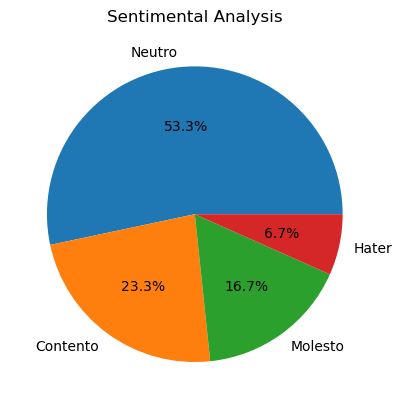

In [53]:
#Generamos el plot con los valores extraídos en la variable anterior y con las etiquetas correspondientes. Le añadimos un 
#título y el porcentaje para completar más la información del plot. 
plt.pie(values_hater, labels=values_hater.index, autopct = "%1.1f%%")
plt.title("Sentimental Analysis")
plt.show()

#### Representación de tweets "positivos"

Realizamos los mismos pasos que en caso anterior pero, en este caso, para la personalidad más positiva. 

In [55]:
positive = tweets[31:]
positive[:5]

,message to examine,label
31,show fun ! ! ! thank much watch . thank play ....,Contento
32,thank everyon listen love ! dont blink youll m...,Contento
33,im go bed - got tomorrow ! !,Neutro
34,wow guess im realli spirit year,Contento
35,guy number 2 ! ! ! omg ! ! ! close ! close ! ! !,Neutro


In [56]:
values_positive = positive.value_counts('label')
values_positive

label
Neutro       13
Contento     11
Molesto       4
Muy feliz     2
Name: count, dtype: int64

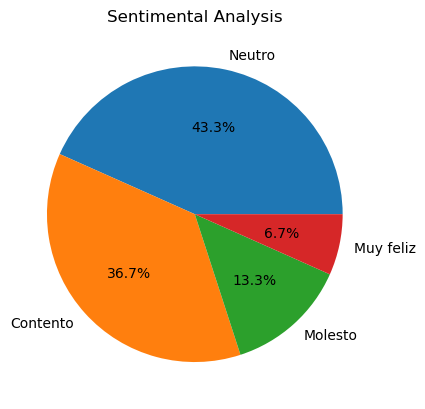

In [57]:
plt.pie(values_positive, labels= values_positive.index, autopct = "%1.1f%%")
plt.title("Sentimental Analysis")
plt.show()